### Tuning hyper-paremter of occipital cell classifier

In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/')

from constants import * 
from base import *
from custom_metrics import *
from tuning_cv import *

In [2]:
## Importing libraries 
import pandas as pd
import numpy as np 
import random 

from sklearn import preprocessing 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

### Importing data 

In [3]:
# Annotated cells 
cell_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Occipital/cells/"
cell_training = "training.txt"

# NNB information of all cells on slide
nnb_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Occipital/NNB/"
nnb_training = "training_NNB.txt"

# hema nucleus of all cells on slide
hema_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/Occipital/hema/"
hema_training = "training_hema.txt"

Require: 
1. input_files.txt - to contian filenames I want to use. ** currently .csv files

In [4]:
# Importing annotated cells 

# obtaining list of files 
with open(cell_path + cell_training) as f: 
    mylist= f.read().splitlines()
    
print("Read in: ",len(mylist),"files")

# reading in all those files 
inputs = [] 
for i in mylist: 
    dat_ = pd.read_csv(cell_path + i,sep=",")
    dat_.columns.values[5] = 'Centroid_X'
    dat_.columns.values[6] = 'Centroid_Y'
    dat = dat_[cell_extracted_features] # fixed extracted feature order
    inputs.append(dat)
print("Extracted:", len(inputs),"files")


Read in:  8 files
Extracted: 8 files


In [5]:
# Importing in neghbouring cells info (numbers)

with open(nnb_path + nnb_training) as f: 
    nb_mylist= f.read().splitlines()
    
print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")

# reading in all those files 
nb_inputs = []
nb_columns = [] 
for i in nb_mylist: 
    dat = pd.read_csv(nnb_path +i,sep=",")
    dat.columns.values[0] = 'X'
    dat.columns.values[1] = 'Y'
    nb_inputs.append(dat)
    nb_columns.append(dat.shape[1])
    
print("Extracted:", len(nb_inputs),"files")
print('no. of columns / NB file:', nb_columns)

Read in: 8  NUMBER OF neighbouring cells files
Extracted: 8 files
no. of columns / NB file: [18, 18, 18, 18, 18, 18, 18, 18]


In [6]:
#  Importing hema nucleus mean of all detected cells & location coordinates 
# Variables: hema_mylist, hema_inputs 

## obtaining list of files 
with open(hema_path + hema_training) as f: 
    hema_mylist= f.read().splitlines()
    
print("Read in:",len(hema_mylist),"hema files")    


## 4) reading in all those files 
hema_inputs = [] 
for i in hema_mylist: 
    dat = pd.read_csv(hema_path + i,sep=",")
    dat.columns.values[0] = 'Centroid_X' # To fix naming inconsistency problem 
    dat.columns.values[1] = 'Centroid_Y'
    hema_inputs.append(dat)

print("Extracted:",len(hema_inputs),"hema files")  


Read in: 8 hema files
Extracted: 8 hema files


In [7]:
# Checking if filenames & order of them from mylist, nb_mylist & hema_mylist match
x_nb = [i[0:6] for i in nb_mylist]
x = [i[0:6] for i in mylist]
x_h = [i[0:6] for i in hema_mylist]
print("mylist & nb_list matched?:", x==x_nb)
print("mylist & hema_list matched?:",x==x_h)

mylist & nb_list matched?: True
mylist & hema_list matched?: True


In [8]:
# combine cells with NNB information
inputs_with_nbb, output_log = combine_annotated_to_NNB2(annotated_list = inputs,
                                   NNB_list = nb_inputs)
print(output_log)

[True, True, True, True, True, True, True, True]


In [9]:
# Find cells to remove based on hematoxylin staining (from normalisation, remove top 1%)
hema_to_remove = find_hema_to_remove(hema_inputs)

# for i in range(0,len(hema_to_remove)): 
#     print(i, " No. of cells with normalised Hema >1:",len(hema_to_remove[i]), "from", len(hema_inputs[i]),"detected cells")

In [10]:
# remove cells that have hema above criteria
cleaned_inputs, remove_log = remove_cell_hema(inputs_with_nbb,
                                              hema_to_remove)
print(remove_log)
print(cleaned_inputs[0].shape)

[True, True, True, True, True, True, True, True]
(420654, 56)


### Putting the slides together 

In [11]:
##Variables: labelled_orig, labelled_data 
#1) Put the slides together

labelled_orig = pd.concat(cleaned_inputs)
print(labelled_orig.shape)

# 2) Extract relevant columns 
dat = labelled_orig.drop(columns=['Name','Parent','ROI']) 
dat.head()


(1031543, 56)


,Image,Class,Centroid_X,Centroid_Y,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,...,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um,NN_110_um,NN_120_um,NN_130_um,NN_140_um,NN_150_um
0,721703.svs,Unlabelled,23317.2,303.63,0.8626,24.0212,17.8053,0.9522,1.0000,6.4203,...,8,8,9,12,17,18,21,27,31,34
1,721703.svs,Unlabelled,23117.0,305.14,0.6539,28.8830,22.6611,0.7068,0.9962,8.9267,...,12,15,18,25,30,36,40,42,47,52
2,721703.svs,Unlabelled,23301.3,310.54,0.8008,57.8022,28.1008,0.9199,1.0000,10.7756,...,9,10,14,17,20,23,27,29,35,39
3,721703.svs,Unlabelled,23204.2,309.59,0.8541,29.3505,21.2158,0.8194,0.9948,7.9087,...,10,13,21,30,34,37,44,47,56,61
4,721703.svs,Unlabelled,23098.8,310.98,0.7954,25.5138,19.5136,0.8420,1.0000,7.4015,...,10,14,19,24,31,37,39,45,50,56


### Extracting relevant cell classes

In [12]:
# Make all class names lower case - easier for later selection

dat_lower_class = [i.lower() for i in dat['Class']]
dat2 = dat.copy()
dat2.loc[:,'Class'] = dat_lower_class 
dat2['Class'].value_counts()

unlabelled    1029835
neuron            476
oligo             445
ignore            244
astro             220
epithelial        159
endo              123
ambiguous          33
fragmented          6
region              2
Name: Class, dtype: int64

In [13]:
# Select only relevant cell classes (Using stardist_error instead of ignore_new)
dat3 = dat2[(dat2['Class'] == 'oligo') | (dat2['Class'] == 'neuron')
          | (dat2['Class'] == 'astro')| (dat2['Class'] == 'epithelial')
          | (dat2['Class'] == 'endo')| (dat2['Class'] == 'fragmented')
          | (dat2['Class'] == 'ignore')]
dat3=dat3.reset_index(drop=True)

# Checking results
dat3['Class'].value_counts()

neuron        476
oligo         445
ignore        244
astro         220
epithelial    159
endo          123
fragmented      6
Name: Class, dtype: int64

In [14]:
cell_code = {'neuron':'Neuron',
             'oligo': 'Oligo',
             'ignore': 'Others',
             'astro':'Astro',
             'epithelial':'Others',
             'endo':'Others',
             'fragmented':'Others'}

In [15]:
# 3) Changing Epithelial to Endothelial
classes = dat3['Class']
formatted_classes = [cell_code[i]  for i in classes]
data = dat3.copy()
data.loc[:,'Class']=formatted_classes

In [16]:
data['Class'].value_counts()

Others    532
Neuron    476
Oligo     445
Astro     220
Name: Class, dtype: int64

In [17]:
# Export cleaned data out for easy use: 
# path = '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Cell_classification/occipital_training_data.txt'
# data.to_csv(path, sep="\t", index=False)

# Training the model

### Checking for any NA in the data

In [18]:
#checking for NAN 
## NEW 
print("Any NA in the data?: ",data.isnull().sum().sum()==1)

#dat = dat.dropna()
#dat.isnull().sum().sum()

Any NA in the data?:  False


### Create train, test sets 

In [19]:
#We are using the entire dataset to train the model, test data will be provided later by Sanne 
X_train_l = data.drop(columns=['Class'])
X_train = X_train_l[training_features]
print('training data shape:',X_train.shape)
y_train = data['Class']

training data shape: (1673, 44)


In [20]:
X_train.head()

,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,Nucleus: Min diameter µm,Cell: Area µm^2,Cell: Length µm,Cell: Circularity,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,0.8900,19.8128,15.8949,0.9855,1.0000,5.2491,4.8900,175.3026,47.1113,0.9925,...,0,0,0,1,5,8,12,16,22,23
1,0.7042,16.1802,16.5761,0.7400,0.9797,6.9006,2.8992,129.4477,44.7169,0.8135,...,0,0,0,2,3,6,8,10,17,21
2,0.9050,40.6065,23.0532,0.9602,1.0000,8.2325,6.4008,170.7491,49.0544,0.8917,...,0,2,2,3,5,5,12,15,17,20
3,0.8948,13.7914,13.2936,0.9807,1.0000,4.3656,4.0313,66.5980,30.8291,0.8805,...,1,2,3,4,4,7,11,15,17,21
4,0.8426,31.2085,20.1525,0.9657,1.0000,7.0218,5.7947,191.4056,50.2637,0.9520,...,0,1,1,4,4,11,12,15,18,23


### Hyperparameter tuning - random forest

In [21]:
pipeline_cell

Pipeline(steps=[('normalizer', MinMaxScaler()),
                ('selector',
                 RFE(estimator=RandomForestClassifier(random_state=42))),
                ('clf', BalancedRandomForestClassifier())])

In [22]:
# # Create the random grid 

rf_random = RandomizedSearchCV(pipeline_cell,
                             param_distributions=random_grid, 
                             n_iter=100,
                             cv=10,
                             verbose=2,
                            random_state=42,
                            n_jobs=-1,
                              refit='PR_AUC', # use this metric to evaluate performance of parameters 
                      scoring={'PR_AUC':precision_recall_auc,
                          'roc_auc_ovr_weighted':'roc_auc_ovr_weighted',
                            'roc_auc_ovo':'roc_auc_ovo',
                              'balanced_accuracy':'balanced_accuracy',
                               'f1_weighted':'f1_weighted',
                               'Astro_accuracy': astro_acc,
                               'Neuron_accuracy':neuron_acc,
                               'Oligo_accuracy':oligo_acc,
                               'Others_accuracy':others_acc,
                               'A_as_N':A_as_N,
                               'A_as_O':A_as_O,
                               'A_as_Others':A_as_Others,
                               'N_as_A':N_as_A,
                               'N_as_O':N_as_O,
                               'N_as_Others':N_as_Others,
                               'O_as_A':O_as_A,
                               'O_as_N':O_as_N,
                               'O_as_Others':O_as_Others,
                               'Others_as_A':Others_as_A,
                               'Others_as_N':Others_as_N,
                               'Others_as_O':Others_as_O
                              })

rf_random.fit(X_train,y_train)

print(rf_random.best_score_)
print(rf_random.best_params_)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
0.8216664745007461
{'selector__n_features_to_select': 28, 'clf__sampling_strategy': 'auto', 'clf__random_state': 42, 'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_samples': 0.25, 'clf__max_features': 0.4, 'clf__max_depth': 15, 'clf__class_weight': 'balanced'}


In [23]:
# # Digging into more details 
print("PR-AUC:",
     rf_random.cv_results_['mean_test_PR_AUC'][rf_random.best_index_]*100)
print("ROC-AUC:",
     rf_random.cv_results_['mean_test_roc_auc_ovr_weighted'][rf_random.best_index_]*100)
print("ROC-AUC:",
     rf_random.cv_results_['mean_test_roc_auc_ovo'][rf_random.best_index_]*100)

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("Astrocyte accuracy:",
      rf_random.cv_results_['mean_test_Astro_accuracy'][rf_random.best_index_]*100)

print("Neuron accuracy:",
      rf_random.cv_results_['mean_test_Neuron_accuracy'][rf_random.best_index_]*100)

print("Oligo accuracy:",
      rf_random.cv_results_['mean_test_Oligo_accuracy'][rf_random.best_index_]*100)

print("Others accuracy:",
      rf_random.cv_results_['mean_test_Others_accuracy'][rf_random.best_index_]*100)


print("Classified A as N:",
      rf_random.cv_results_['mean_test_A_as_N'][rf_random.best_index_]*100)

print("Classified A as O:",
      rf_random.cv_results_['mean_test_A_as_O'][rf_random.best_index_]*100)

print("Classified A as Others:",
      rf_random.cv_results_['mean_test_A_as_Others'][rf_random.best_index_]*100)

print("Classified N as A:",
      rf_random.cv_results_['mean_test_N_as_A'][rf_random.best_index_]*100)

print("Classified N as O:",
      rf_random.cv_results_['mean_test_N_as_O'][rf_random.best_index_]*100)

print("Classified N as Others:",
      rf_random.cv_results_['mean_test_N_as_Others'][rf_random.best_index_]*100)

print("Classified O as A:",
      rf_random.cv_results_['mean_test_O_as_A'][rf_random.best_index_]*100)

print("Classified O as N:",
      rf_random.cv_results_['mean_test_O_as_N'][rf_random.best_index_]*100)

print("Classified O as Others:",
      rf_random.cv_results_['mean_test_O_as_Others'][rf_random.best_index_]*100)


print("Classified Others as A:",
      rf_random.cv_results_['mean_test_Others_as_A'][rf_random.best_index_]*100)

print("Classified Others as N:",
      rf_random.cv_results_['mean_test_Others_as_N'][rf_random.best_index_]*100)

print("Classified Others as O:",
      rf_random.cv_results_['mean_test_Others_as_O'][rf_random.best_index_]*100)
                                                       

PR-AUC: 82.16664745007462
ROC-AUC: 94.20266572463532
ROC-AUC: 93.6550503661078
Balanced accuracy: 76.23116358621678
F1_weighted: 76.67301223437664
Astrocyte accuracy: 77.72727272727272
Neuron accuracy: 76.1081560283688
Oligo accuracy: 77.01515151515152
Others accuracy: 74.07407407407408
Classified A as N: 12.272727272727273
Classified A as O: 5.90909090909091
Classified A as Others: 4.090909090909091
Classified N as A: 19.069148936170212
Classified N as O: 0.6294326241134751
Classified N as Others: 4.1932624113475185
Classified O as A: 13.520202020202019
Classified O as N: 0.0
Classified O as Others: 9.464646464646464
Classified Others as A: 7.9070580013976235
Classified Others as N: 8.256464011180993
Classified Others as O: 9.76240391334731


PR-AUC: 82.3283186466039
ROC-AUC: 94.54264534146078
ROC-AUC: 93.67747875139247
Balanced accuracy: 73.11913612912207
F1_weighted: 75.07087599855163
Astrocyte accuracy: 63.63636363636365
Neuron accuracy: 75.05319148936171
Oligo accuracy: 69.18181818181817
Others accuracy: 84.6051712089448
Classified A as N: 15.909090909090908
Classified A as O: 6.8181818181818175
Classified A as Others: 13.636363636363635
Classified N as A: 13.60372340425532
Classified N as O: 0.42109929078014185
Classified N as Others: 10.921985815602838
Classified O as A: 11.484848484848484
Classified O as N: 0.0
Classified O as Others: 19.333333333333332
Classified Others as A: 3.76659678546471
Classified Others as N: 5.433263452131376
Classified Others as O: 6.19496855345912

In [24]:
# save object using joblib
joblib.dump(rf_random, 'occipital_random_search_param.sav')

['occipital_random_search_param.sav']

## Manual cross validation, using PR curves

{'selector__n_features_to_select': 28, 'clf__sampling_strategy': 'auto',
'clf__random_state': 42, 'clf__n_estimators': 200, 'clf__min_samples_split': 10,
 'clf__min_samples_leaf': 4, 'clf__max_samples': 0.25, 'clf__max_features': 0.4,
  'clf__max_depth': 15, 'clf__class_weight': 'balanced'}






In [25]:
occipital_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(estimator=RandomForestClassifier(random_state=42),
        n_features_to_select=28)),
    ('clf', BalancedRandomForestClassifier(
        random_state=42,
        sampling_strategy='auto',
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features=0.4,
        max_depth=15,
        max_samples=0.25,
        class_weight='balanced'))]
        
# 10-fold cross validation
model = ClassifierTuning(hyperparameters=occipital_classifier_hyperparams)
model.find_bestparameters(X=X_train,
                          Y=y_train)

In [26]:
model.best_parameters

{0: (0.46755140108518506,
  0.64622061572346,
  0.5524263118410125,
  0.809090909090909),
 1: (0.35800301310120014,
  0.8404223852097499,
  0.8257465256800274,
  0.8658687943262411),
 2: (0.38978088189514104,
  0.8427582788906303,
  0.8476453077212108,
  0.848989898989899),
 3: (0.3327053512581415,
  0.833597139312819,
  0.8379277250873924,
  0.8324248777078965)}

In [27]:
model.cv_withthresholding(best_parameters=model.best_parameters,
                          X=X_train,
                          Y=y_train,
                          X_location = X_train_l)

In [76]:
# Confusion matrix across 10 folds, WITH thresholding 
print('with thresholding (non-calibrated) ACC :', mean(model.cv_accuraciesT)*100)
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reportsT])*100)
print("--------------------------")
cf_t = sum(model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100
print(cf_t)
print(final_cm_t)
print("--------------------------")
print("Astro accuracy",final_cm_t[0][0])
print("Neuron accuracy",final_cm_t[1][1])
print("Oligo accuracy",final_cm_t[2][2])
print("Oligo accuracy",final_cm_t[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reportsT])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reportsT])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reportsT])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reportsT])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

with thresholding (non-calibrated) ACC : 77.91207169224646
Macro avg F1  76.8218656934271
Weighted avg F1  79.9003109885956
--------------------------
[[133  27  16  12]
 [ 56 351   2  21]
 [ 49   0 328  33]
 [ 22  35  38 390]]
[[70.74468085 14.36170213  8.5106383   6.38297872]
 [13.02325581 81.62790698  0.46511628  4.88372093]
 [11.95121951  0.         80.          8.04878049]
 [ 4.53608247  7.21649485  7.83505155 80.41237113]]
--------------------------
Astro accuracy 70.74468085106383
Neuron accuracy 81.62790697674419
Oligo accuracy 80.0
Oligo accuracy 80.41237113402062
------------------------------
Astro f1-score  59.729222190917255
Astro precision  53.17730443672543
Astro recall  70.59301998311285
--------------------------
Neuron f1-score  82.88110364140384
Neuron precision  85.71956963779358
Neuron recall  81.27070739515678
--------------------------
Oligo f1-score  81.65528295986947
Oligo precision  85.30762131102107
Oligo recall  79.38855040432794
--------------------------
O

In [28]:
model.cv_nothresholding(X=X_train,
                        Y=y_train,
                        X_location= X_train_l)

In [29]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
cf = sum(model.cv_confusion_matrices)
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100
print(cf)
print(final_cm)
print("--------------------------")
print("Astro accuracy",final_cm[0][0])
print("Neuron accuracy",final_cm[1][1])
print("Oligo accuracy",final_cm[2][2])
print("Others accuracy",final_cm[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reports])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reports])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reports])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reports])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reports])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reports])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reports])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reports])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 76.23116358621678
Macro avg F1  74.25835608035094
Weighted avg F1  76.67301223437664
--------------------------
[[171  27  13   9]
 [ 91 362   3  20]
 [ 60   0 343  42]
 [ 42  44  52 394]]
[[77.72727273 12.27272727  5.90909091  4.09090909]
 [19.11764706 76.05042017  0.6302521   4.20168067]
 [13.48314607  0.         77.07865169  9.43820225]
 [ 7.89473684  8.27067669  9.77443609 74.06015038]]
--------------------------
Astro accuracy 77.72727272727272
Neuron accuracy 76.05042016806722
Oligo accuracy 77.07865168539327
Others accuracy 74.06015037593986
------------------------------
Astro f1-score  58.88147497663627
Astro precision  48.11715988731095
Astro recall  77.72727272727272
--------------------------
Neuron f1-score  79.38266964139594
Neuron precision  84.59753638845648
Neuron recall  76.1081560283688
--------------------------
Oligo f1-score  79.692940655675
Oligo precision  83.7338166806667
Oligo recall  77.01515151515152
--------------------------
Others f1

In [30]:
# save object using joblib
joblib.dump(model, 'occipital_cv_results.sav')

['occipital_cv_results.sav']

Extracting information

In [21]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Results/occipital_cv_results.sav')
cf_t = sum(loaded_model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100

In [22]:
# find out proportion of ambiguous cells 
predicted = (sum(loaded_model.cv_y_predictsT, []))
print('total:',len(predicted))
print(set(predicted))
amb_n = sum(1 for i in predicted if i =='Ambiguous')
print('Ambiguous: ',amb_n)
print('proportion Ambiguous: ', amb_n/len(predicted) )

total: 1673
{'Ambiguous', 'Others', 'Astro', 'Oligo', 'Neuron'}
Ambiguous:  143
proportion Ambiguous:  0.08547519426180514


In [23]:
final_cm_t

array([[75.74257426, 13.86138614,  5.44554455,  4.95049505],
       [14.35079727, 81.54897494,  0.22779043,  3.87243736],
       [12.62135922,  0.        , 79.12621359,  8.25242718],
       [ 5.87002096,  7.1278826 ,  7.75681342, 79.24528302]])

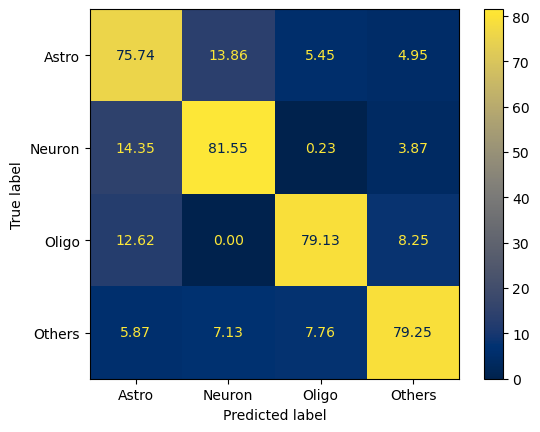

In [24]:
plot = ConfusionMatrixDisplay(final_cm_t,
                              display_labels=['Astro', 'Neuron', 'Oligo', 'Others'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [25]:
model = loaded_model
# Confusion matrix across 10 folds, WITH thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

Macro avg F1  77.43601480090445
Macro avg F1 std  4.935887564355875
--------------------------
Macro avg precision 78.31481200805567
Macro avg precision std 4.646789178745521
--------------------------
Macro avg recall  78.86361082652195
Macro avg recall std 5.182427039837196


In [26]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  74.25835608035094
Macro avg F1 std  4.036685691317849
--------------------------
Macro avg precision 75.4659910488987
Macro avg precision std 3.833671344344553
--------------------------
Macro avg recall  76.23116358621678
Macro avg recall std 4.386092317636649


Plotting feature importance

In [27]:
import seaborn as sns

In [29]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Results/occipital_random_search_param.sav')

In [30]:
model_rf.best_params_

{'selector__n_features_to_select': 28,
 'clf__sampling_strategy': 'auto',
 'clf__random_state': 42,
 'clf__n_estimators': 200,
 'clf__min_samples_split': 10,
 'clf__min_samples_leaf': 4,
 'clf__max_samples': 0.25,
 'clf__max_features': 0.4,
 'clf__max_depth': 15,
 'clf__class_weight': 'balanced'}

In [31]:
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [X_train.columns[i] for i in rf_result]
# (rf_result_f)
importance = model_rf.best_estimator_.named_steps['clf'].feature_importances_
f_importance = pd.DataFrame(data={'features':rf_result_f,'importance':importance})
f_importance = f_importance.sort_values(by=['importance'],ascending=False)

In [32]:
f_importance_subset = f_importance[0:11]
features = [i.replace('ROI: 0.25 µm per pixel: ','') for i in f_importance_subset['features']]
f_importance_subset = f_importance_subset.copy()
f_importance_subset.loc[:,'features'] = features
f_importance_subset = f_importance_subset.rename(columns={'features':'Feature',
                                    'importance':'Importance'})

In [33]:
f_importance_subset

,Feature,Importance
1,Nucleus: Area µm^2,0.132467
4,Nucleus: Max diameter µm,0.124573
0,Detection probability,0.117742
2,Nucleus: Length µm,0.117511
5,Nucleus: Min diameter µm,0.079836
3,Nucleus: Circularity,0.049216
9,Cell: Max diameter µm,0.046391
7,Cell: Length µm,0.044891
13,Hematoxylin: Nucleus: Median,0.027784
12,Hematoxylin: Nucleus: Mean,0.022275


<Axes: xlabel='Importance', ylabel='Feature'>

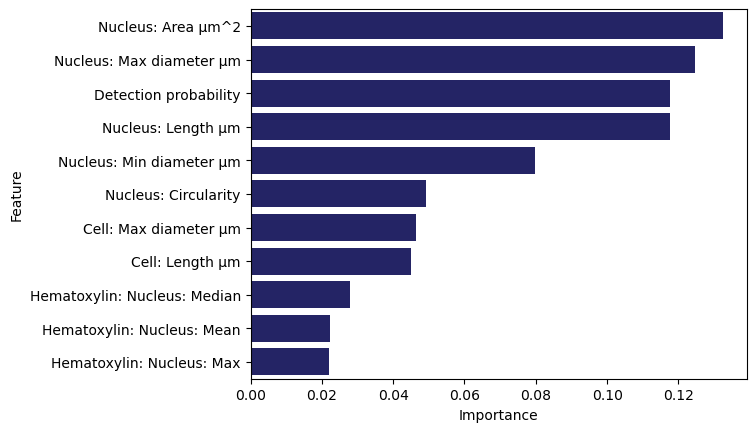

In [34]:
sns.barplot(data=f_importance_subset,
            y="Feature",
            x="Importance",
            color='midnightblue')

In [35]:
keys = ['split0_test_PR_AUC',
        'split1_test_PR_AUC',
        'split2_test_PR_AUC',
        'split3_test_PR_AUC',
        'split4_test_PR_AUC',
        'split5_test_PR_AUC',
        'split6_test_PR_AUC',
        'split7_test_PR_AUC',
        'split8_test_PR_AUC',
        'split9_test_PR_AUC']
pr_val = []
for i in keys:
    pr_val.append(model_rf.cv_results_[i][model_rf.best_index_])

In [36]:
print(model_rf.cv_results_['mean_test_PR_AUC'][model_rf.best_index_]*100)
print('mean pr:', mean(pr_val)*100)
print('std pr:', np.std(pr_val)*100)

82.16664745007462
mean pr: 82.16664745007462
std pr: 5.183142184242165
